In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, epps_singleton_2samp
import matplotlib.patches as mpatches

----------------------


# Top-level view of SD2 protein design data

----------------------

__TODO__: 
* explain why `NTF2` is dropped
* explain what `stabilityscore_cnn_calibrated` means, and why we binarize
* explain why S_pc is used as variable name

In [4]:
#show total number of entries, topologies used
data = pd.read_csv('./data/df_aggregated_spc.csv')

#NTF2 topology should not be used so remove those rows (stability score does not map equally to other topologies)
ntf2_inx = data[data['topology']=='NTF2'].index 
data = data.drop(ntf2_inx)

print("Total number of entries --> %s"%len(data))
print("Total number of topologies --> %s"%len(data.topology.unique()))
print("")

# define rosetta features
ros_features = pd.read_csv('./data/rosetta_features.csv')['0'].to_list()

# define entropy features
spc_features = pd.read_csv('./data/entropy_features.csv')["0"].to_list()

# define stability ('stable'/'unstable')
data['stabilityscore_cnn_calibrated_2classes'] = data['stabilityscore_cnn_calibrated'] > 1
stable_proteins = data[data['stabilityscore_cnn_calibrated_2classes']==1]
unstable_proteins = data[data['stabilityscore_cnn_calibrated_2classes']==0]


Total number of entries --> 80257
Total number of topologies --> 11



# Visualize Features for Classification

In [5]:
from HelperFunctions.feature_visualizations import show_all_plots

In [6]:
plt.rc('font', family='serif') # change font types for plots
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

## Topology-unspecified

TODO: 
* add note explaining what is important to look at in these following plots

Number of Unstable: 68715
number of Stable: 11542


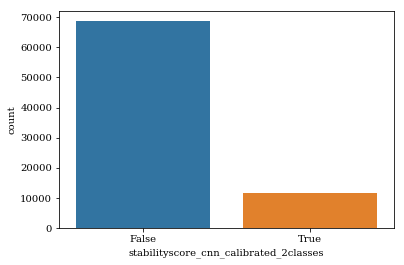

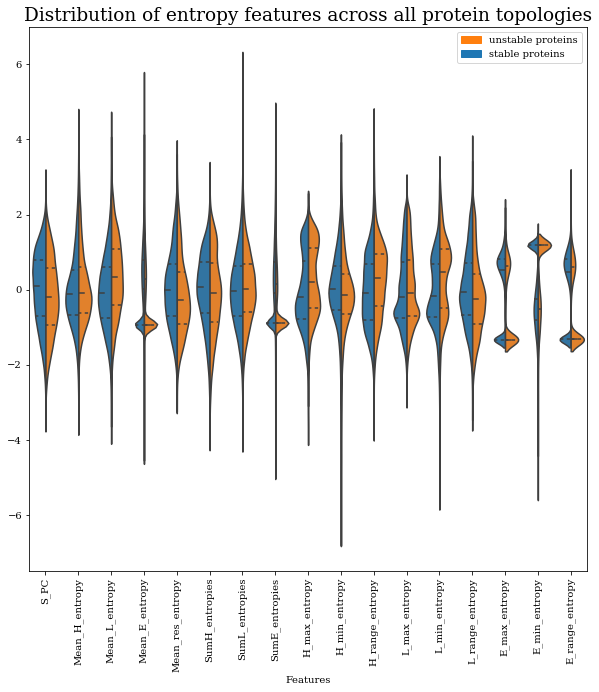

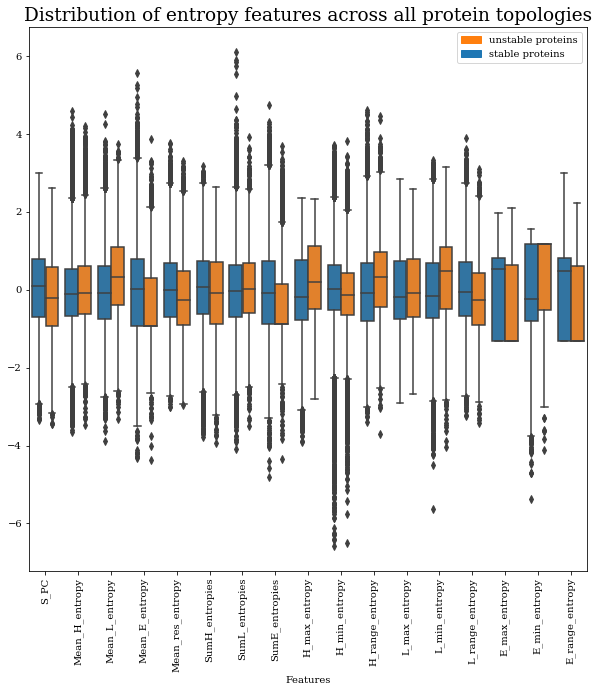

In [13]:
# show boxplot of all features (dataframe_visualizations/SD2 Feature Visualizations)
show_all_plots(data=data, 
               features=spc_features, 
               target='stabilityscore_cnn_calibrated_2classes',
               title_name='Distribution of entropy features across all protein topologies')


## Topology-specified
TODO:
* add notes explaining what specific plots one should pay attention to

--------- Distributions for 4h topology ----------
Number of Unstable: 13226
number of Stable: 1466


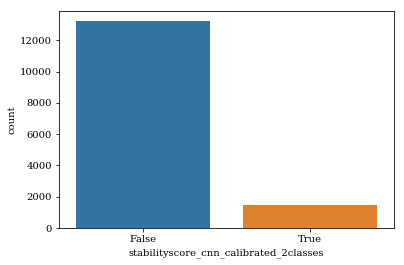

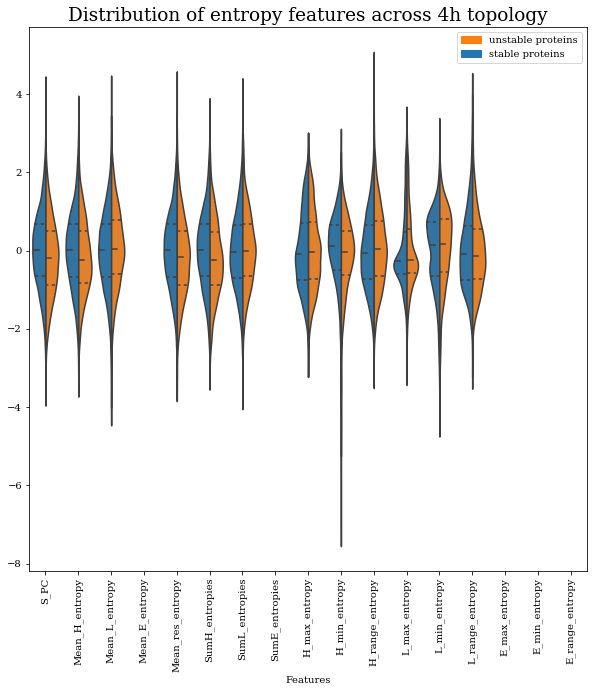

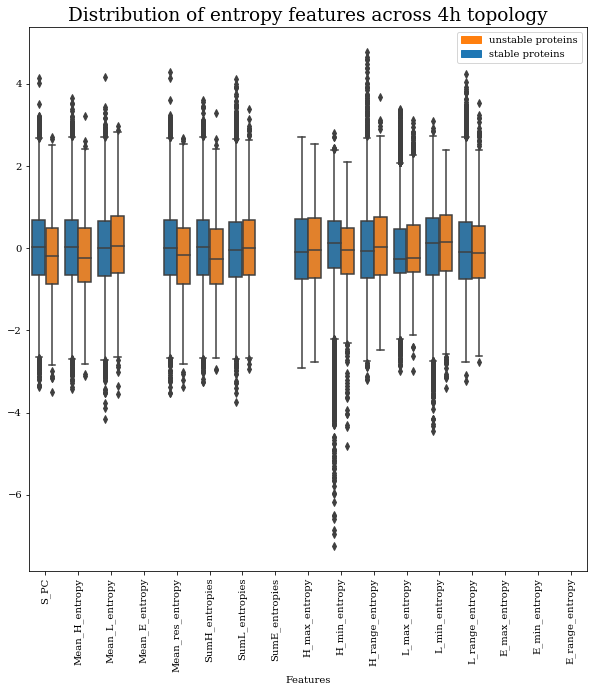

--------- Distributions for ferredoxin topology ----------
Number of Unstable: 13263
number of Stable: 1122


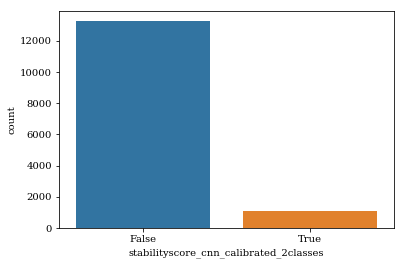

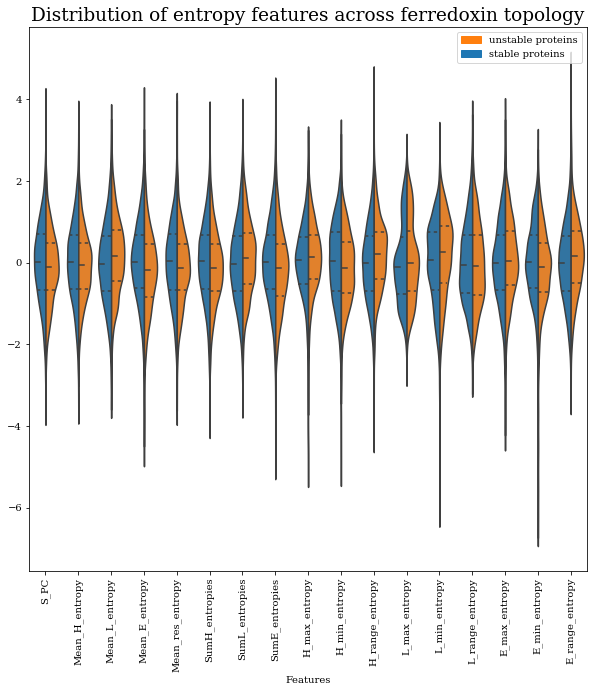

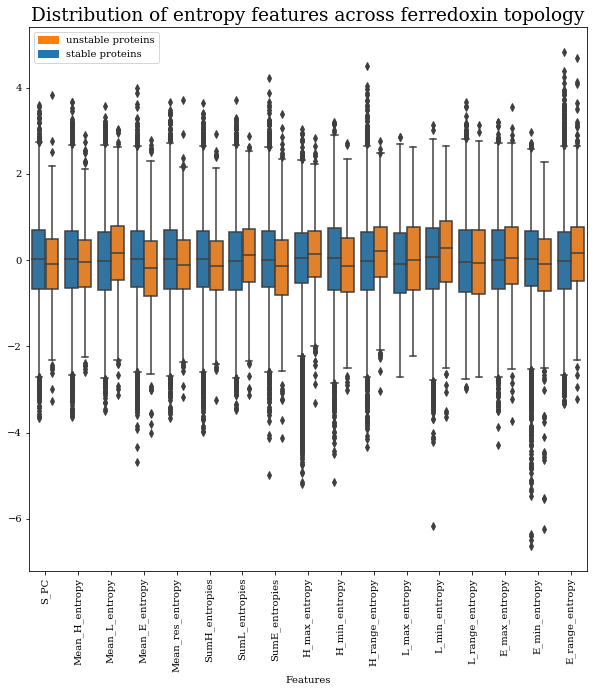

--------- Distributions for beta_grasp topology ----------
Number of Unstable: 2268
number of Stable: 106


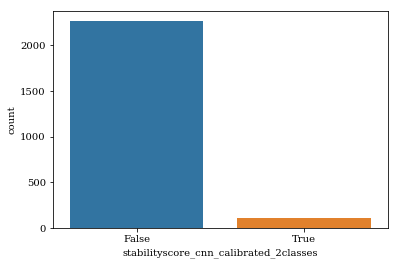

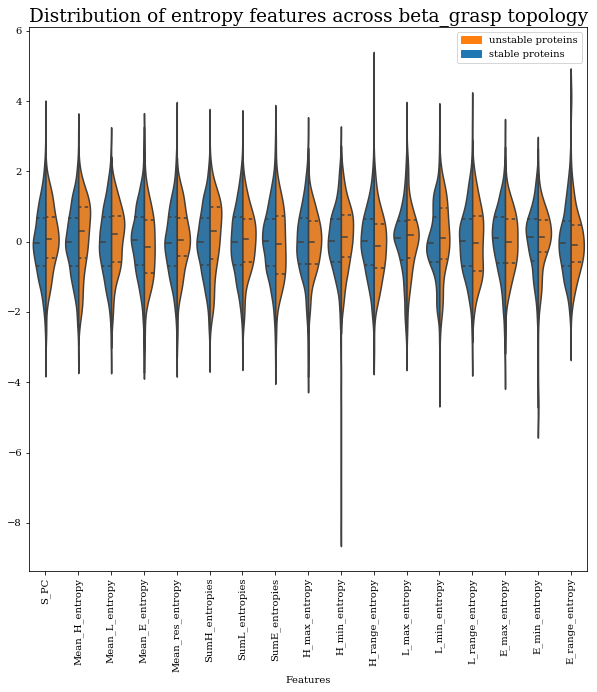

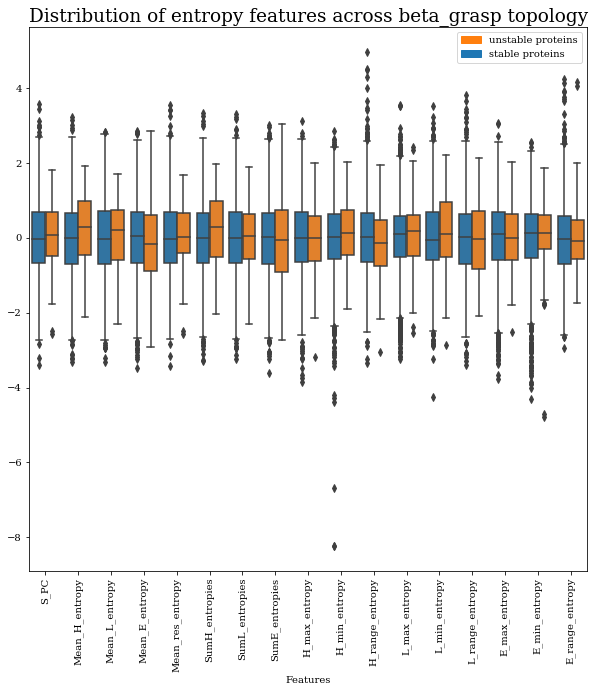

--------- Distributions for thio topology ----------
Number of Unstable: 1997
number of Stable: 49


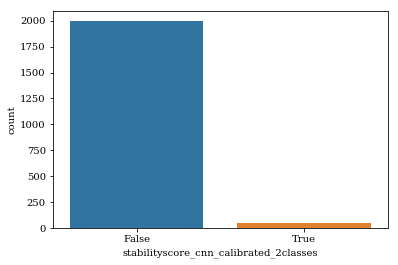

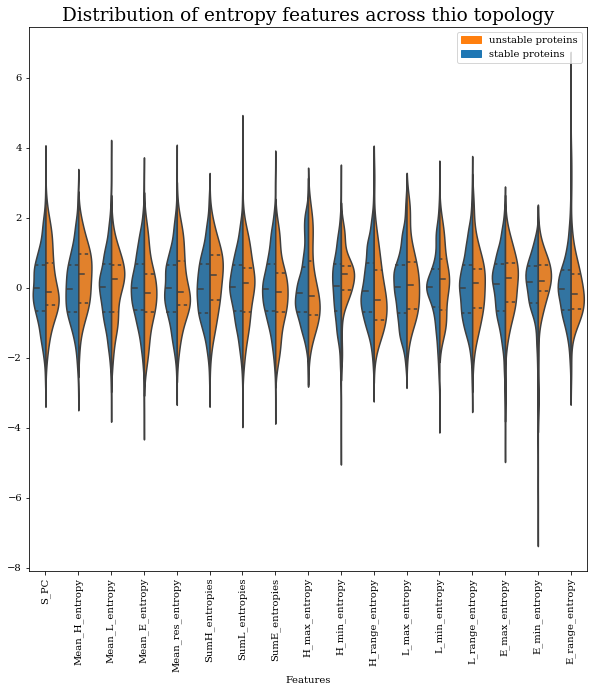

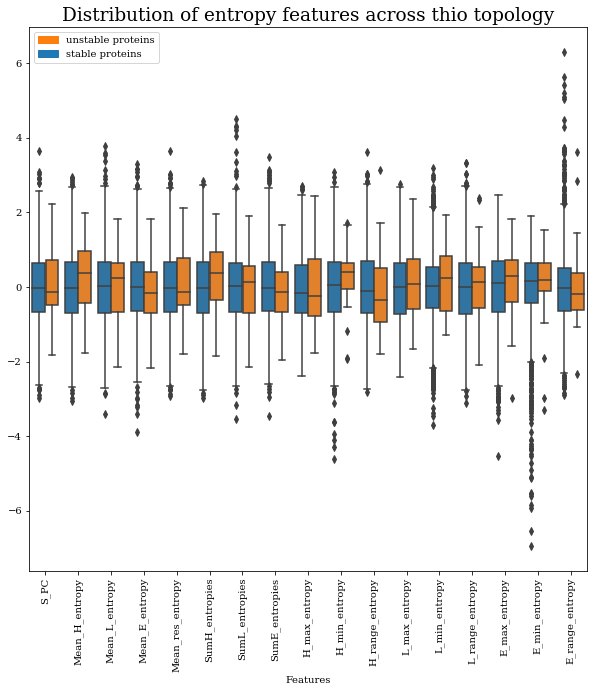

--------- Distributions for fold2 topology ----------
Number of Unstable: 582
number of Stable: 75


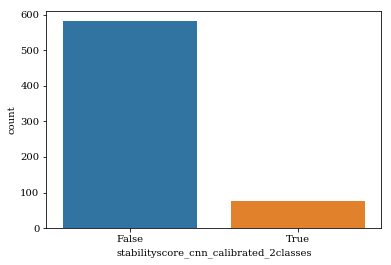

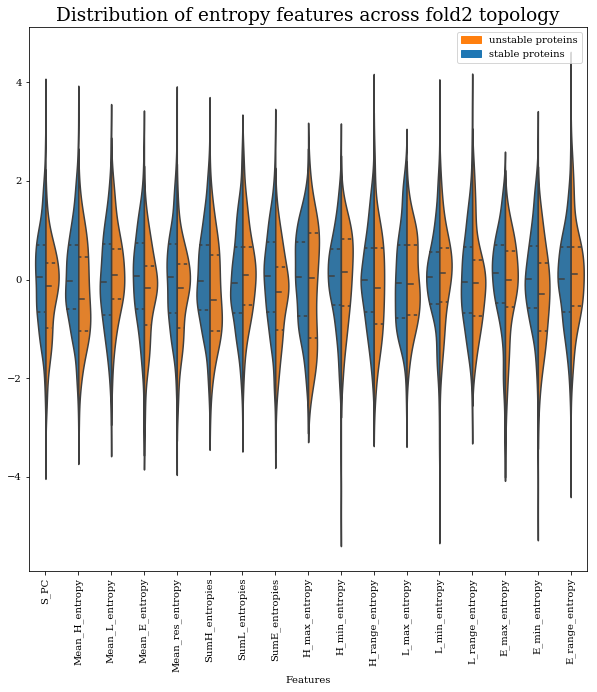

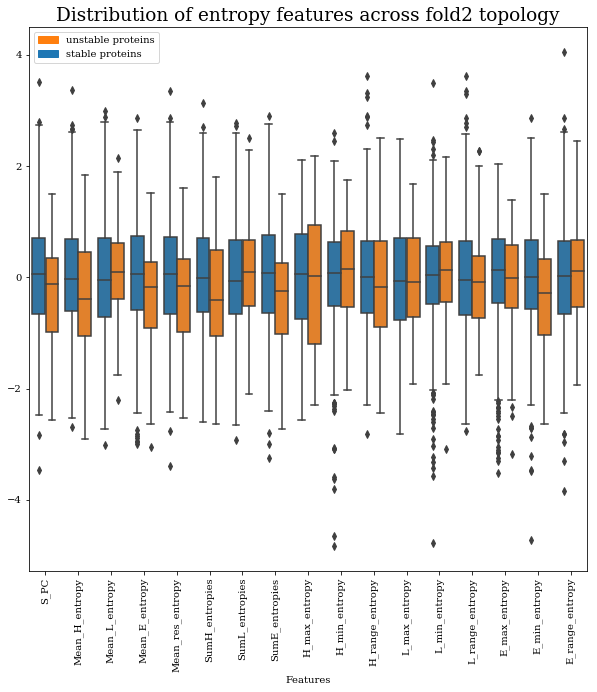

--------- Distributions for coil topology ----------
Number of Unstable: 547
number of Stable: 26


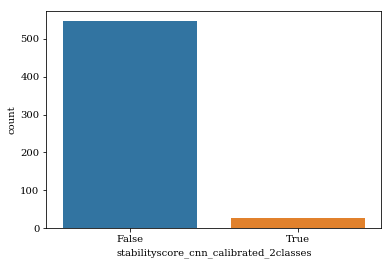

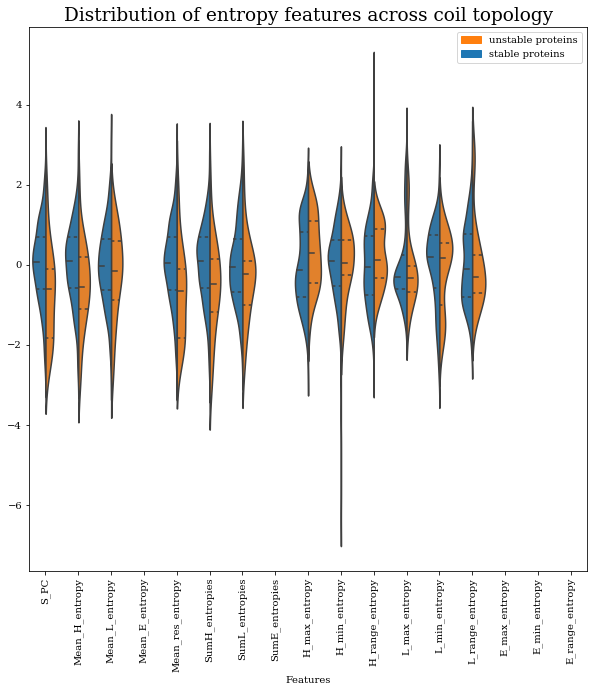

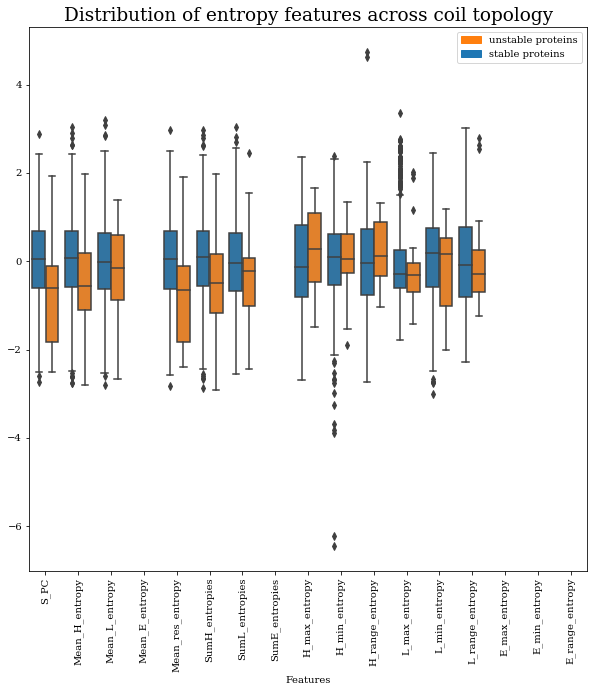

--------- Distributions for fold4 topology ----------
Number of Unstable: 237
number of Stable: 18


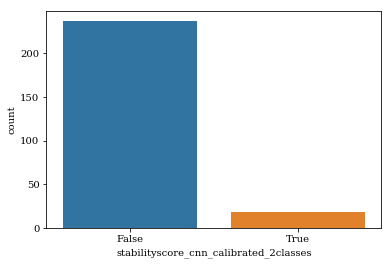

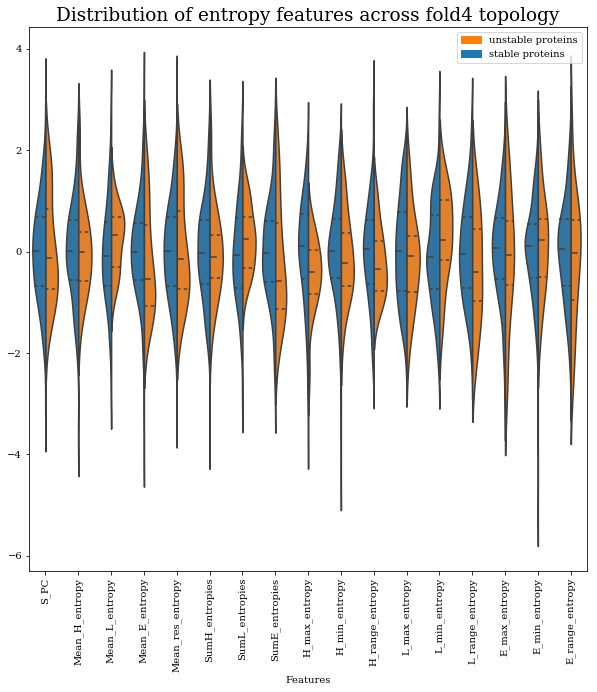

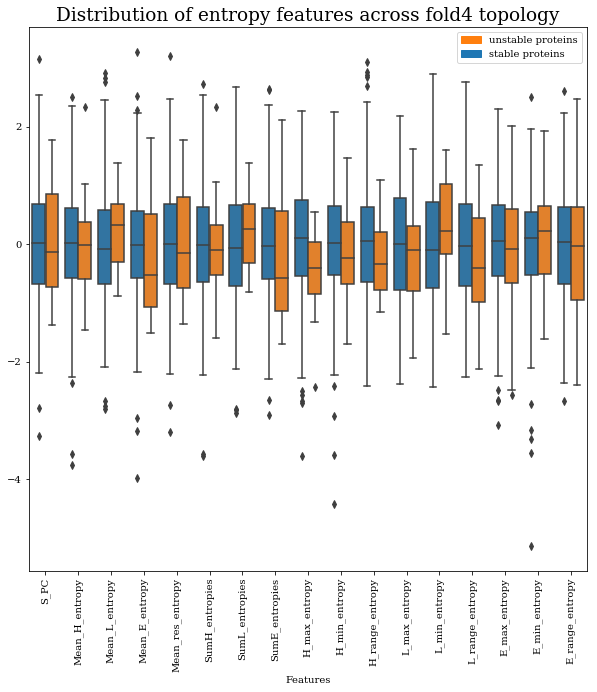

--------- Distributions for HHH topology ----------
Number of Unstable: 7275
number of Stable: 4741


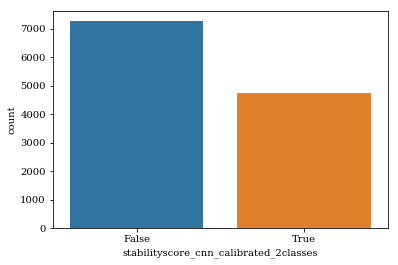

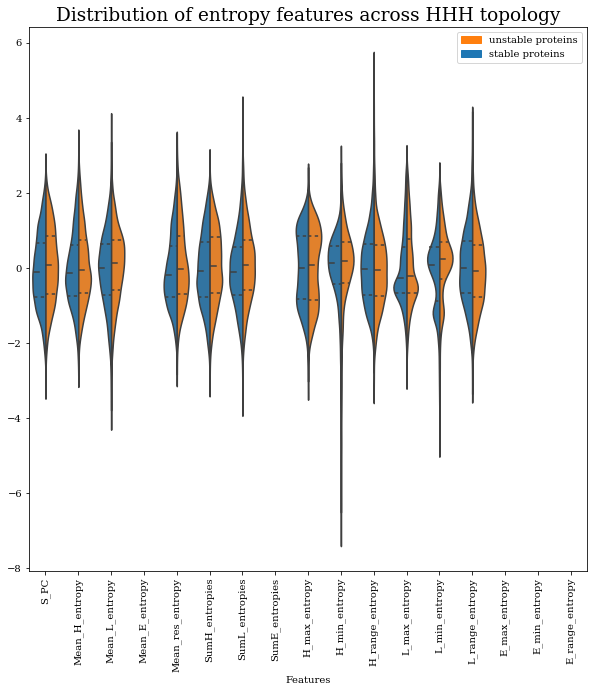

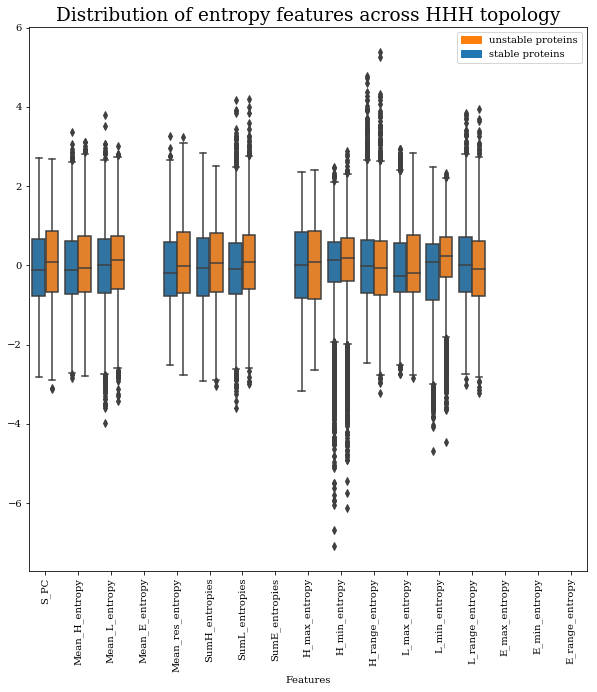

--------- Distributions for EEHEE topology ----------
Number of Unstable: 9009
number of Stable: 706


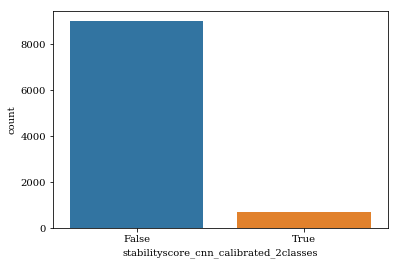

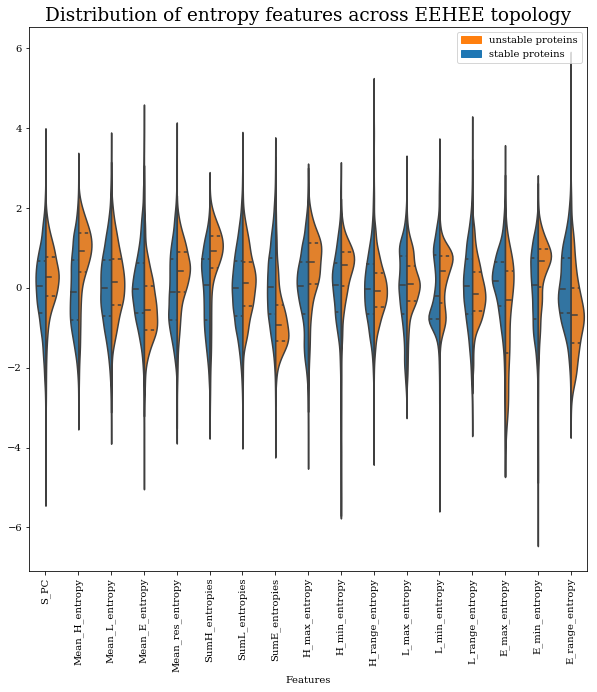

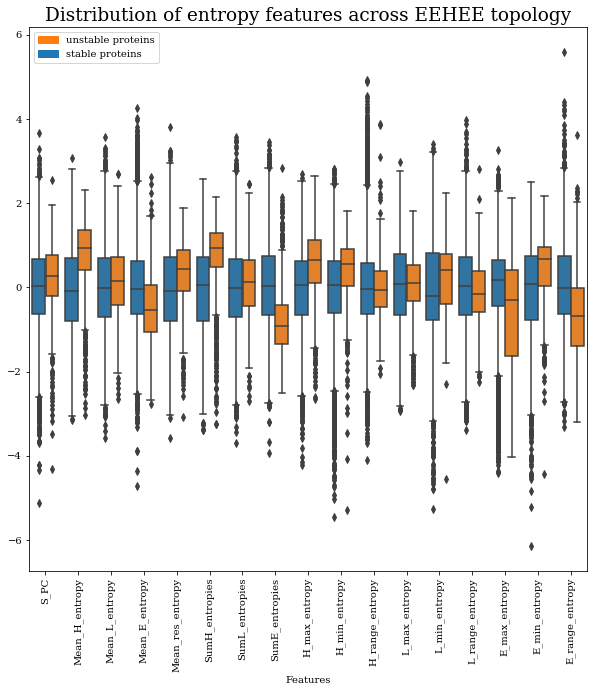

--------- Distributions for EHEE topology ----------
Number of Unstable: 5435
number of Stable: 1210


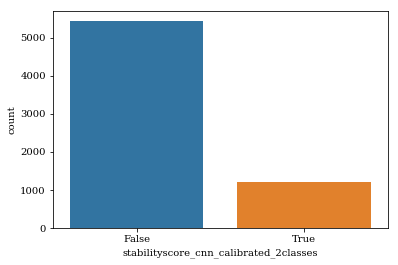

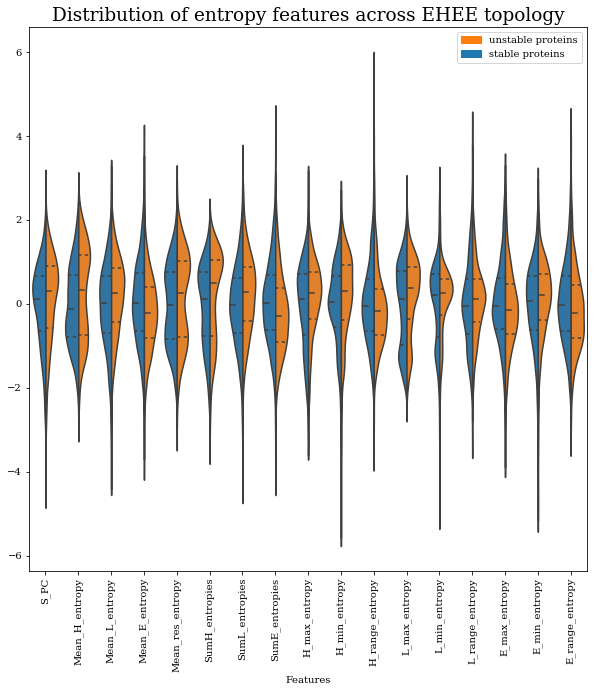

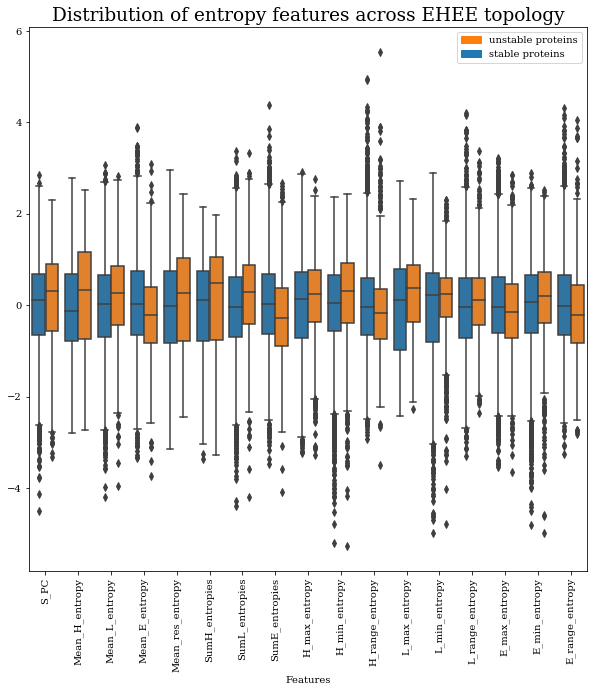

--------- Distributions for HEEH topology ----------
Number of Unstable: 14876
number of Stable: 2023


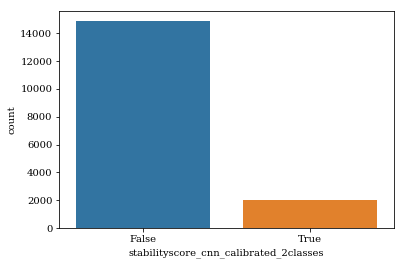

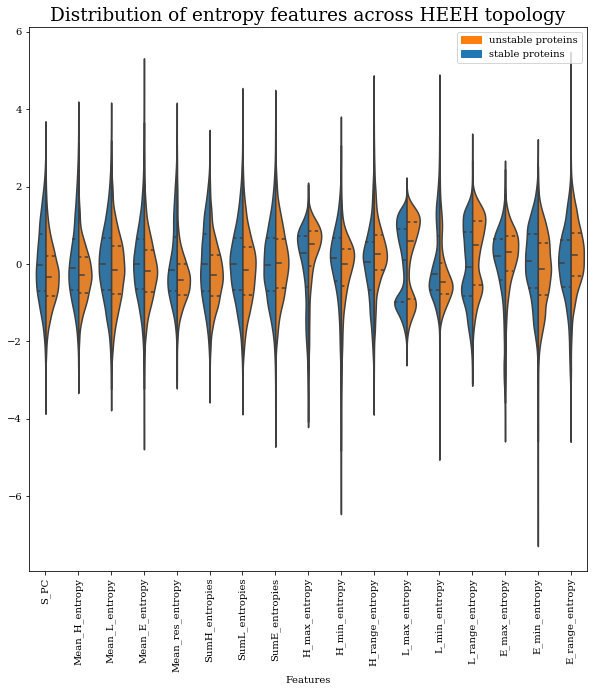

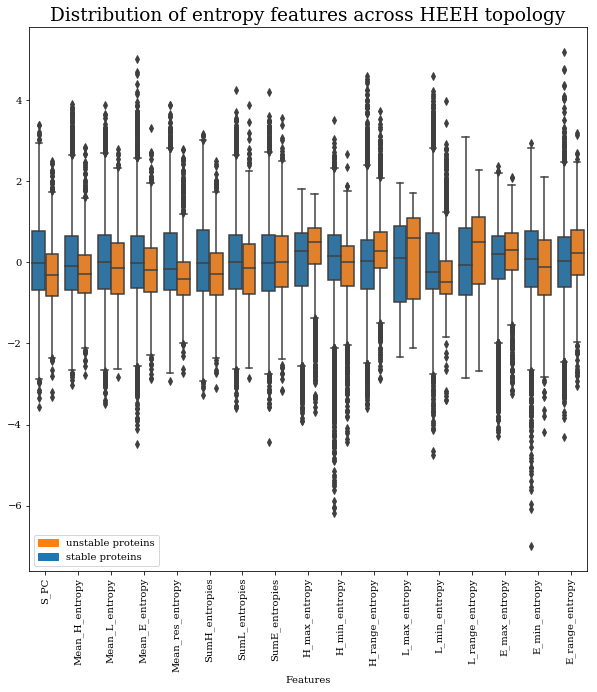

In [15]:
#show plots for all features per topology

#get a list of topologies
topologies_list = list(data['topology'].unique())

for topology in topologies_list:
    print("--------- Distributions for %s topology ----------"%topology)
    
    #subset the data to specify for a topology
    df = data[data['topology']==topology]
    
    #plot distributions for subset
    show_all_plots(data=df, 
               features=spc_features, 
               target='stabilityscore_cnn_calibrated_2classes',
               title_name='Distribution of entropy features across %s topology'%topology)

    

----------------------

# Kolmogorov-Smirnov (KS) Test for 'stable' and 'unstable' distributions

----------------------

## TODO:
* explain what `is_rosetta` column means
* explain motivation for finding KS values

## Topology-unspecified

In [10]:
from scipy.stats import ks_2samp

# get KS values for all features
rows = []
for fet in spc_features:
    subset_stable = stable_proteins[fet]
    subset_unstable = unstable_proteins[fet]
    
    ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
    rows.append([fet,ks_value,False,p_value]) #third row corresponds to 'is_rosetta' column

for fet in ros_features:
    subset_stable = stable_proteins[fet]
    subset_unstable = unstable_proteins[fet]
    
    ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
    rows.append([fet,ks_value,True,p_value])

    
    
#make a dataframe from ks value data
ks_values_all = pd.DataFrame(rows,columns=['Feature','KS','is_rosetta','P-value'])

#subset for entropy feature ks values and rosetta feature ks values
ks_values_all_spc = ks_values_all[ks_values_all['is_rosetta']==False]
ks_values_all_ros = ks_values_all[ks_values_all['is_rosetta']==True]


#get index of row with highest ks value for entropy and rosetta feature subset
spc_max_inx = ks_values_all_spc['KS'].idxmax()
ros_max_inx = ks_values_all_ros['KS'].idxmax()

In [11]:
print("Entropy feature with highest KS Value:\n",ks_values_all.iloc[spc_max_inx,:])
print()
print("Rosetta feature with highest KS Value\n",ks_values_all.iloc[ros_max_inx,:])

Entropy feature with highest KS Value:
 Feature       E_max_entropy
KS                 0.233719
is_rosetta            False
P-value                   0
Name: 14, dtype: object

Rosetta feature with highest KS Value
 Feature       avg_best_frag
KS                 0.361311
is_rosetta             True
P-value                   0
Name: 27, dtype: object


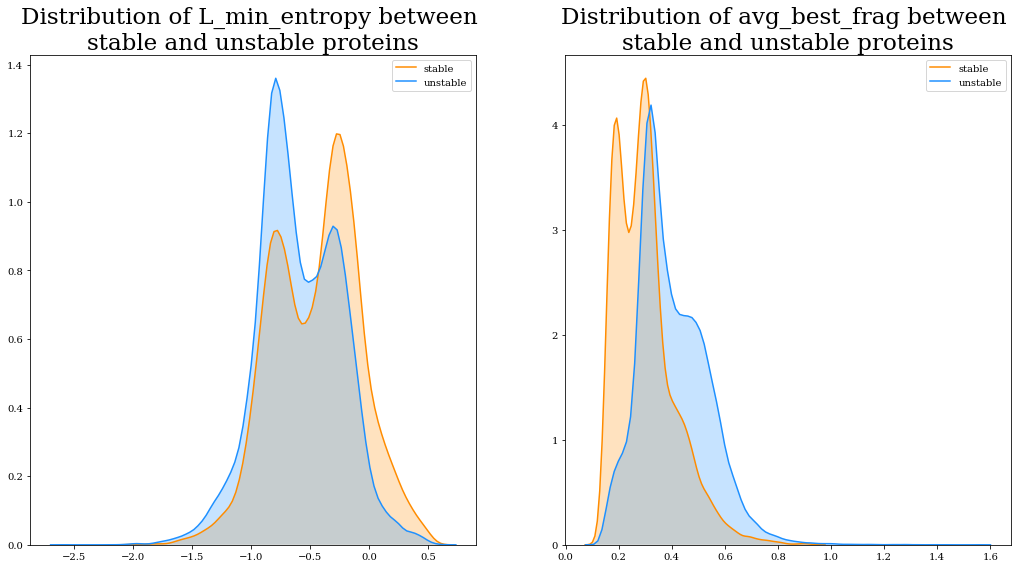

In [12]:
fets = ['L_min_entropy','avg_best_frag']
f, ax = plt.subplots(1,2,figsize=[15,8])
for i in range(len(fets)):
    fet = fets[i]
    sns.kdeplot(data=stable_proteins[fet],label='stable',shade=True,ax=ax[i],color='darkorange')
    sns.kdeplot(data=unstable_proteins[fet],label='unstable',shade=True,ax=ax[i],color='dodgerblue')
    ax[i].set_title("Distribution of %s between \nstable and unstable proteins"%(fet),fontsize='23')
    
plt.tight_layout()

## TODO: 
* explain why `E_range_entropy` == `E_max_entropy`

In [13]:
# show entropy features ranked by KS value
ks_values_all_spc[ks_values_all_spc['P-value']<.05].sort_values(by='KS',ascending=False)

,Feature,KS,is_rosetta,P-value
16,E_range_entropy,0.233719,False,0.000000e+00
14,E_max_entropy,0.233719,False,0.000000e+00
15,E_min_entropy,0.233253,False,0.000000e+00
3,Mean_E_entropy,0.219145,False,0.000000e+00
7,SumE_entropies,0.219145,False,0.000000e+00
12,L_min_entropy,0.184505,False,1.264329e-292
2,Mean_L_entropy,0.161355,False,6.686678e-224
10,H_range_entropy,0.144643,False,5.250187e-180
8,H_max_entropy,0.135258,False,1.859491e-157
0,S_PC,0.105591,False,3.975463e-96


## Topology-specified

## N.B.:
* not all entropy features are showing for each topology because we are only showing those with p_value < .05

* **IMPORTANT**: SciPy _needs_ to be version 1.3.0, since its `ks_2samp` function is more accurate than the 1.2.x version I was previously using

In [16]:
rows = []

for topology in topologies_list:
    stable_top_specific = stable_proteins[stable_proteins['topology']==topology]
    unstable_top_specific = unstable_proteins[unstable_proteins['topology']==topology]
    

    for fet in spc_features:
        subset_stable = stable_top_specific[fet]
        subset_unstable = unstable_top_specific[fet]

        ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
        rows.append([fet,ks_value,False,topology,p_value]) #third row corresponds to 'is_rosetta' column

    for fet in ros_features:
        subset_stable = stable_top_specific[fet]
        subset_unstable = unstable_top_specific[fet]

        ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
        rows.append([fet,ks_value,True,topology,p_value])
    
    

In [17]:
ks_values_topology = pd.DataFrame(rows,columns=['Feature','KS','is_rosetta','topology','P-value'])
ks_values_topology_spc = ks_values_topology[ks_values_topology['is_rosetta']==False].reset_index(drop=True)
ks_values_topology_ros = ks_values_topology[ks_values_topology['is_rosetta']==True].reset_index(drop=True)

In [18]:
#show entropy features ranked by KS value for each topology.
df = ks_values_topology_spc[ks_values_topology_spc['P-value']<.05].sort_values(by='KS',ascending=False)
for topology in topologies_list:
    print("\t TOPOLOGY --> %s"%topology)
    print(df[df['topology']==topology])
    print()

	 TOPOLOGY --> 4h
             Feature        KS  is_rosetta topology       P-value
5     SumH_entropies  0.115372       False       4h  1.104171e-15
1     Mean_H_entropy  0.114603       False       4h  1.760869e-15
0               S_PC  0.089316       False       4h  1.434538e-09
4   Mean_res_entropy  0.086368       False       4h  5.626970e-09
9      H_min_entropy  0.085904       False       4h  6.948911e-09
10   H_range_entropy  0.046820       False       4h  6.141417e-03
12     L_min_entropy  0.041484       False       4h  2.129706e-02

	 TOPOLOGY --> ferredoxin
             Feature        KS  is_rosetta    topology       P-value
27   H_range_entropy  0.111798       False  ferredoxin  1.175939e-11
22    SumH_entropies  0.095049       False  ferredoxin  1.524946e-08
20    Mean_E_entropy  0.092258       False  ferredoxin  4.498617e-08
26     H_min_entropy  0.091111       False  ferredoxin  6.949401e-08
33   E_range_entropy  0.089613       False  ferredoxin  1.216890e-07
24    SumE_en

In [19]:
#show Rosetta features ranked by KS value for each topology.
df = ks_values_topology_ros[ks_values_topology_ros['P-value']<.05].sort_values(by='KS',ascending=False)
for topology in topologies_list:
    print("\t TOPOLOGY --> %s"%topology)
    print(df[df['topology']==topology])
    print()

	 TOPOLOGY --> 4h
                        Feature        KS  is_rosetta topology        P-value
17           buried_np_AFILMVWY  0.448109        True       4h  1.329924e-230
18   buried_np_AFILMVWY_per_res  0.445253        True       4h  1.116334e-227
19            buried_np_per_res  0.421940        True       4h  1.669246e-204
76            n_hydrophobic_noA  0.412548        True       4h  1.607671e-195
62            hphob_sc_contacts  0.405712        True       4h  4.158524e-189
..                          ...       ...         ...      ...            ...
61                        holes  0.042917        True       4h   1.547868e-02
4                     Tend_netq  0.040471        True       4h   2.651423e-02
83    nearest_tryp_cut_to_Nterm  0.040360        True       4h   2.715434e-02
101                         ref  0.039211        True       4h   3.456214e-02
96                         pack  0.037665        True       4h   4.730005e-02

[89 rows x 5 columns]

	 TOPOLOGY --> ferredo

[107 rows x 5 columns]



In [20]:
# Highest KS value for Entropy Feature in a topology:
spc_max_inx = ks_values_topology_spc['KS'].idxmax()

In [21]:
# Highest KS value for Rosetta Feature in a topology:
ros_max_inx = ks_values_topology_ros['KS'].idxmax()

In [22]:
print("Entropy feature-topology pair with highest KS Value:\n",ks_values_topology_spc.iloc[spc_max_inx,:])
print()
print("Rosetta feature-topology pair with highest KS Value\n",ks_values_topology_ros.iloc[ros_max_inx,:])

Entropy feature-topology pair with highest KS Value:
 Feature       SumE_entropies
KS                  0.421752
is_rosetta             False
topology               EEHEE
P-value         1.41449e-101
Name: 143, dtype: object

Rosetta feature-topology pair with highest KS Value
 Feature       contig_not_hp_avg
KS                     0.648746
is_rosetta                 True
topology                  EEHEE
P-value            9.29069e-240
Name: 930, dtype: object


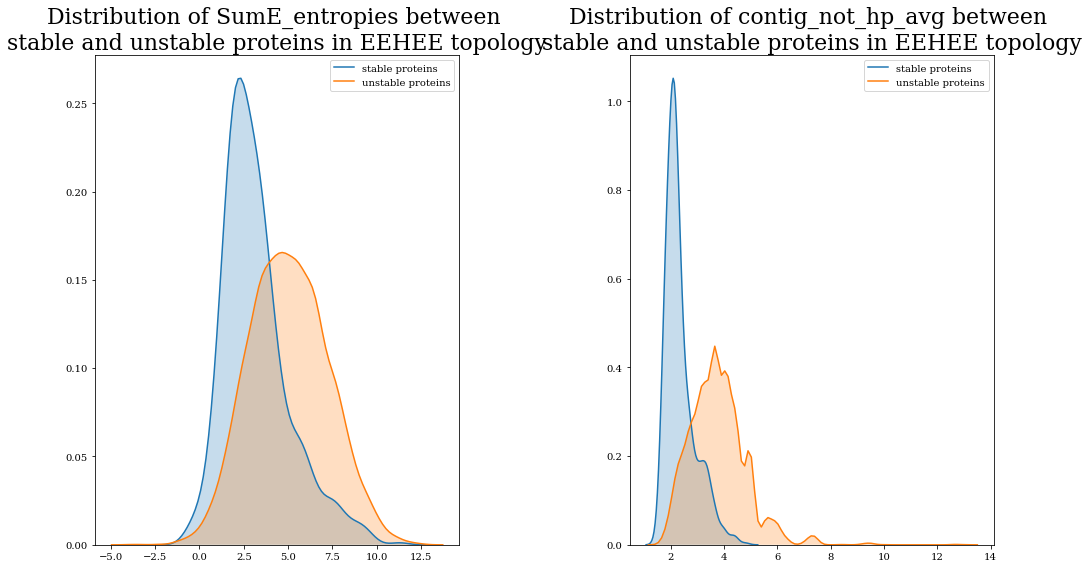

In [23]:
pairs = (['EEHEE','SumE_entropies'],['EEHEE','contig_not_hp_avg'])
f, ax = plt.subplots(1,2,figsize=[15,8])
for i in range(len(pairs)):
    top, fet = pairs[i]
    sns.kdeplot(data=stable_proteins[stable_proteins['topology']==top][fet],label='stable proteins',shade=True,ax=ax[i],color='tab:blue')
    sns.kdeplot(data=unstable_proteins[unstable_proteins['topology']==top][fet],label='unstable proteins',shade=True,ax=ax[i],color='tab:orange')
    ax[i].set_title("Distribution of %s between \nstable and unstable proteins in %s topology"%(fet,top),fontsize='22')
    
plt.tight_layout()

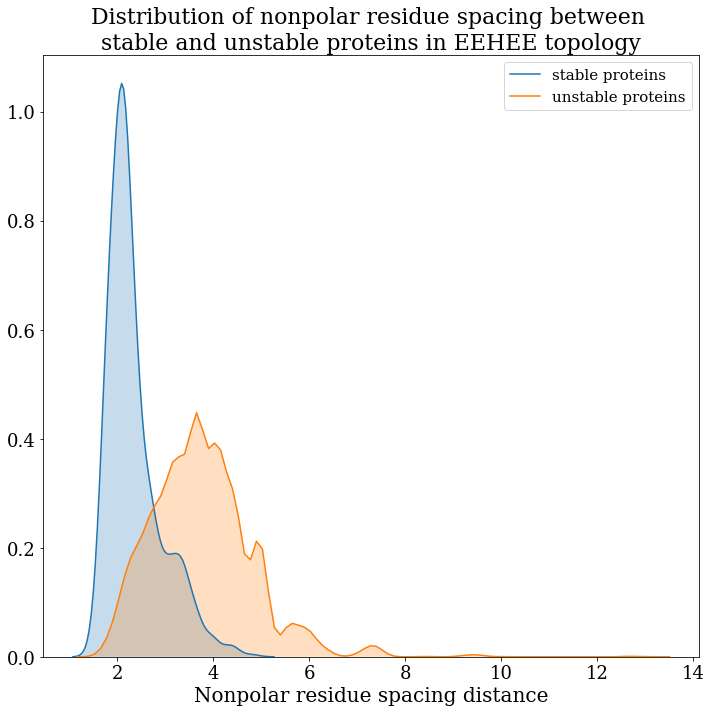

In [24]:
f,ax = plt.subplots(figsize=[10,10])
top, fet = pairs[1]
sns.kdeplot(data=stable_proteins[stable_proteins['topology']==top][fet],label='stable proteins',shade=True,ax=ax,color='tab:blue')
sns.kdeplot(data=unstable_proteins[unstable_proteins['topology']==top][fet],label='unstable proteins',shade=True,ax=ax,color='tab:orange')
ax.set_title("Distribution of nonpolar residue spacing between \nstable and unstable proteins in %s topology"%(top),fontsize='22')
plt.xticks(fontsize="18")
plt.xlabel("Nonpolar residue spacing distance",fontsize="20")
plt.yticks(fontsize="18")
plt.legend(fontsize="15")
plt.tight_layout()

plt.savefig("Figure3c",bbox_inches='tight',dpi=300)

----------------------

# Epps-Singleton (ES) Test for 'stable' and 'unstable' distributions

----------------------

## TODO:
* explain why ES test is good
* explain motivation for finding ES values

## Topology-unspecified

In [ ]:
# get ES values for all features
rows = []
for fet in spc_features:
    try:
        subset_stable = stable_proteins[fet]
        subset_unstable = unstable_proteins[fet]

        es_value, p_value = epps_singleton_2samp(subset_stable,subset_unstable)
        rows.append([fet,es_value,False,p_value]) #third row corresponds to 'is_rosetta' column
    except:
        print("%s Feature did not work"%fet)
for fet in ros_features:
    try:
        subset_stable = stable_proteins[fet]
        subset_unstable = unstable_proteins[fet]
    
        es_value, p_value = epps_singleton_2samp(subset_stable,subset_unstable)
        rows.append([fet,es_value,True,p_value])
    except:
        print("%s Feature did not work"%fet)
    

In [ ]:
#make a dataframe from ES value data
es_values_all = pd.DataFrame(rows,columns=['Feature','ES','is_rosetta','P-value'])

#subset for entropy feature ks values and rosetta feature ks values
es_values_all_spc = es_values_all[es_values_all['is_rosetta']==False]
es_values_all_ros = es_values_all[es_values_all['is_rosetta']==True]


#get index of row with highest ks value for entropy and rosetta feature subset
spc_max_inx = es_values_all_spc['ES'].idxmax()
ros_max_inx = es_values_all_ros['ES'].idxmax()

In [ ]:
print("Entropy feature with highest ES Value:\n",es_values_all.iloc[spc_max_inx,:])
print()
print("Rosetta feature with highest ES Value\n",es_values_all.iloc[ros_max_inx,:])

In [ ]:
# show entropy features ranked by ES value
es_values_all_spc[es_values_all_spc['P-value']<.05].sort_values(by='ES',ascending=False)

## Topology-specified

## N.B.:
* not all entropy features are showing for each topology because we are only showing those with p_value < .05

* **IMPORTANT**: SciPy _needs_ to be version 1.3.0, since its `epps_singleton_2samp` function is more accurate than the 1.2.x version I was previously using

In [ ]:
rows = []

for topology in topologies_list:
    stable_top_specific = stable_proteins[stable_proteins['topology']==topology]
    unstable_top_specific = unstable_proteins[unstable_proteins['topology']==topology]
    
    #print("\t%s"%topology)
    for fet in spc_features:
        try:
            subset_stable = stable_top_specific[fet]
            subset_unstable = unstable_top_specific[fet]

            es_value, p_value = epps_singleton_2samp(subset_stable,subset_unstable)
            rows.append([fet,es_value,False,topology,p_value]) #third row corresponds to 'is_rosetta' column
        except:
            #print("%s Feature in %s topology did not work"%(fet,topology))
            pass
    print()
    for fet in ros_features:
        try:
            subset_stable = stable_top_specific[fet]
            subset_unstable = unstable_top_specific[fet]

            es_value, p_value = epps_singleton_2samp(subset_stable,subset_unstable)
            rows.append([fet,es_value,True,topology,p_value])
        except:
            #print("%s Feature in %s topology did not work"%(fet,topology))
            pass
    #print()
    #print()

es_values_topology = pd.DataFrame(rows,columns=['Feature','ES','is_rosetta','topology','P-value'])
es_values_topology_spc = es_values_topology[es_values_topology['is_rosetta']==False].reset_index(drop=True)
es_values_topology_ros = es_values_topology[es_values_topology['is_rosetta']==True].reset_index(drop=True)

#show entropy features ranked by KS value for each topology.
df = es_values_topology_spc[es_values_topology_spc['P-value']<.05].sort_values(by='ES',ascending=False)
for topology in topologies_list:
    print("\t TOPOLOGY --> %s"%topology)
    print(df[df['topology']==topology])
    print()

In [ ]:
# Highest KS value for Entropy Feature in a topology:
spc_max_inx = es_values_topology_spc['ES'].idxmax()

# Highest KS value for Rosetta Feature in a topology:
ros_max_inx = es_values_topology_ros['ES'].idxmax()

print("Entropy feature with highest ES Value:\n",es_values_topology_spc.iloc[spc_max_inx,:])
print()
print("Rosetta feature with highest ES Value\n",es_values_topology_ros.iloc[ros_max_inx,:])

In [ ]:
pairs = (['HEEH','Mean_res_entropy'],['EEHEE','exposed_np_AFILMVWY'])
f, ax = plt.subplots(1,2,figsize=[15,8])
for i in range(len(pairs)):
    top, fet = pairs[i]
    sns.kdeplot(data=stable_proteins[stable_proteins['topology']==top][fet],label='stable',shade=True,ax=ax[i])
    sns.kdeplot(data=unstable_proteins[unstable_proteins['topology']==top][fet],label='unstable',shade=True,ax=ax[i])
    ax[i].set_title("Distribution of %s between \nstable and unstable proteins in %s topology"%(fet,top))
    
plt.tight_layout()

----------------------

# Change in Test Statistics Across 100 Iterations of Test Harness runs with Random Forest Classifier

----------------------

**TODO**: 
- explain the Test Harness
- explain why we want to look at TP and FP rates

In [ ]:
def get_tptn_data(dataframe, 
                  real_value='stabilityscore_cnn_calibrated_2classes',
                 predicted_value='stabilityscore_cnn_calibrated_2classes_predictions',return_count=True):
    #get all 0's and all 1's
    positives = dataframe[dataframe['stabilityscore_cnn_calibrated_2classes']==1]
    negatives = dataframe[dataframe['stabilityscore_cnn_calibrated_2classes']==0]


    tp = positives[positives['stabilityscore_cnn_calibrated_2classes_predictions']==1]
    tn = negatives[negatives['stabilityscore_cnn_calibrated_2classes_predictions']==0]

    fp = negatives[negatives['stabilityscore_cnn_calibrated_2classes_predictions']==1]
    fn = positives[positives['stabilityscore_cnn_calibrated_2classes_predictions']==0]
    if return_count !=True:
        return tp,tn,fp,fn
    return len(tp),len(tn),len(fp),len(fn)

In [ ]:
#load leaderboard
leaderboard = pd.read_html('./data/cross_val_tptn_classification_leaderboard.html')[0]

In [ ]:
#get names of rosetta runs
rosetta_runs = leaderboard[leaderboard['Data and Split Description']=='R']
rosetta_runs_names = list(rosetta_runs['Run ID'].values)

In [ ]:
#get names of R+S runs
entropy_rosetta_runs = leaderboard[leaderboard['Data and Split Description']=='RS']
entropy_rosetta_runs_names = list(entropy_rosetta_runs['Run ID'].values)

### Rosetta Model TPTN data extraction

In [ ]:
# "R" Model

#initialize dataframe that will contain data
ros_df = pd.DataFrame()
ros_df['TP Count'] = []
ros_df['FP Count'] = []
ros_df['TN Count'] = []
ros_df['FN Count'] = []

#initialize empty lists for data
ros_tp_data = []
ros_tn_data = []
ros_fp_data = []
ros_fn_data = []

#loop through files
for run_name in rosetta_runs_names:
    df = pd.read_csv('./test_harness_runs/tptn_runs/run_%s/testing_data.csv'%run_name)
    tp,tn,fp,fn = get_tptn_data(df)

    #update the lists
    ros_tp_data.append(tp)
    ros_tn_data.append(tn)
    ros_fp_data.append(fp)
    ros_fn_data.append(fn)

#construct final dataframe
ros_df['TP Count'] = ros_tp_data
ros_df['FP Count'] = ros_fp_data
ros_df['FN Count'] = ros_fn_data
ros_df['TN Count'] = ros_tn_data

In [ ]:
ros_df.describe()

### Rosetta+Entropy Model TPTN data extraction

In [ ]:
# "R+S" Model

#initialize dataframe that will contain data
spc_df = pd.DataFrame()
spc_df['TP Count'] = []
spc_df['FP Count'] = []
spc_df['TN Count'] = []
spc_df['FN Count'] = []

#initialize empty lists for data
spc_tp_data = []
spc_tn_data = []
spc_fp_data = []
spc_fn_data = []

#loop through files
for run_name in entropy_rosetta_runs_names:
    df = pd.read_csv('./test_harness_runs/tptn_runs/run_%s/testing_data.csv'%run_name)
    tp,tn,fp,fn = get_tptn_data(df)

    #update the lists
    spc_tp_data.append(tp)
    spc_tn_data.append(tn)
    spc_fp_data.append(fp)
    spc_fn_data.append(fn)

#construct final dataframe
spc_df['TP Count'] = spc_tp_data
spc_df['FP Count'] = spc_fp_data
spc_df['FN Count'] = spc_fn_data
spc_df['TN Count'] = spc_tn_data

In [ ]:
spc_df.describe()

In [ ]:
results = spc_df.describe() - ros_df.describe()
results.iloc[1,:]